# W+c Analysis (charm tagging)

This analysis will focus on the selection of W+c Events for c-tagging study. The dataset used for this is: [W1JetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8](https://opendata.cern.ch/record/69544).

In [1]:
import ROOT as rt
import uproot as uprt
import mplhep as mh
import matplotlib.pyplot as plt
import awkward as ak
import numpy as np

In [2]:
# Defining the style for plots (CMS Style)
plt.style.use(mh.style.CMS)
plt.rcParams.update({
    "font.size": 17,
    "axes.labelsize": 17,
    "axes.titlesize": 17,
    "xtick.labelsize": 17,
    "ytick.labelsize": 17,
    "legend.fontsize": 17
})

# Defining the function for making histograms
def make_hist(data, bins, range, xlabel, ylabel, label, fname=None, logy=False):
    histo, edges = np.histogram(data, bins=bins, range=range)
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    mh.histplot(histo, edges, histtype="step", label=label, ax=ax)
    mh.cms.label("Open Data", data=True, lumi=None, com=13, year=2016, loc=0)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    if logy:
        ax.set_yscale("log")
    if fname:
        plt.savefig(fname)
    plt.show()

In [3]:
# Loading the ROOT file
# btvNanoAODFile = uprt.open("../datasets/nano106X_on_mini106X_2017_mc_NANOAOD_W1Jets_to_LNu_5K.root")
# Events = btvNanoAODFile["Events"]

# Loading the ROOT File (1K events)
btvNanoAODFile_1K = uprt.open("../datasets/nano106X_on_mini106X_2017_mc_NANOAOD_W1Jets_to_LNu.root")
Events = btvNanoAODFile_1K["Events"]

# # Loading the Central NANOAOD file
# NANOAODFile = uprt.open("../datasets/W1JetsToLNu_TuneCP5_13TeV_NANOAODSIM.root")
# Events = NANOAODFile["Events"]

In [4]:
# We are interested in the RecoJets collections
RecoJet_keys = Events.keys(filter_name="Jet_*")
for RecoJets in Events.iterate(RecoJet_keys, step_size=Events.num_entries, library="ak"):
    break
# RecoJets

In [5]:
# Muons and electrons Collections
RecoMuon_keys = Events.keys(filter_name="Muon_*")
for RecoMuons in Events.iterate(RecoMuon_keys, step_size=Events.num_entries, library="ak"):
    break

RecoElectron_keys = Events.keys(filter_name="Electron_*")
for RecoElectrons in Events.iterate(RecoElectron_keys, step_size=Events.num_entries, library="ak"):
    break

In [6]:
# # We are also interested in the GenJets collections
# GenJet_keys = Events.keys(filter_name="GenJet_*")
# for GenJets in Events.iterate(GenJet_keys, step_size=Events.num_entries, library="ak"):
#     break
# # GenJets

# MET collection
MET_keys = Events.keys(filter_name="MET_*")
for METs in Events.iterate(MET_keys, step_size=Events.num_entries, library="ak"):
    break

## W $\rightarrow$ $\mu + \nu$ Event Selection:

This part of the notebook selects all the events that pass the following cuts:
- Jet $p_{T}$ > 30 GeV
- Muon $p_{T}$ > 20 GeV
- Muon $\eta$ > 2.4
- Muon_pfRelIso04_all > 0.15
- $M_{T}$ > 55 GeV
- Events with two opposite signed muons with $p_{T}$ > 20 GeV

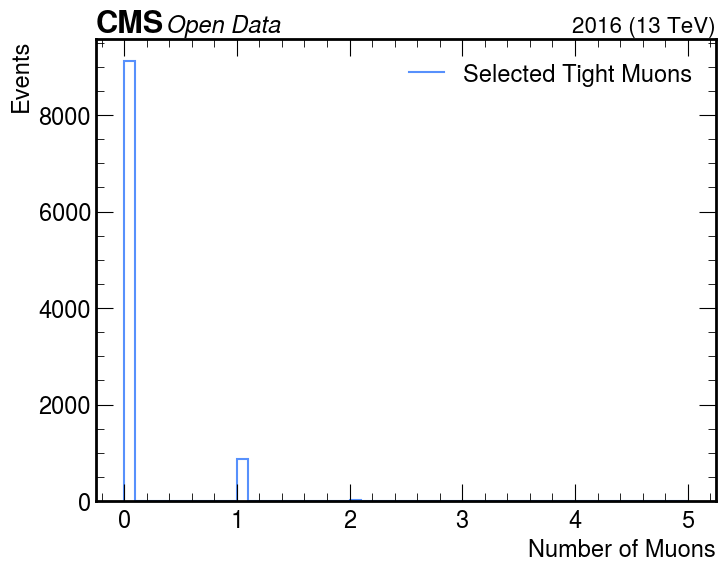

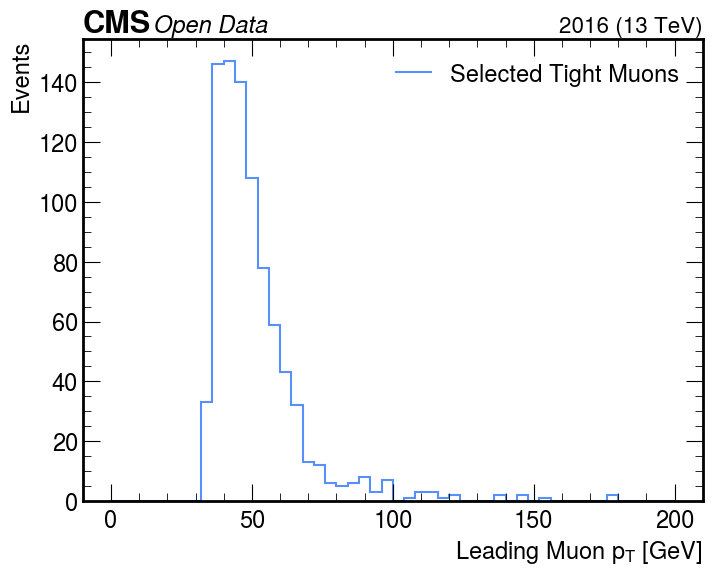

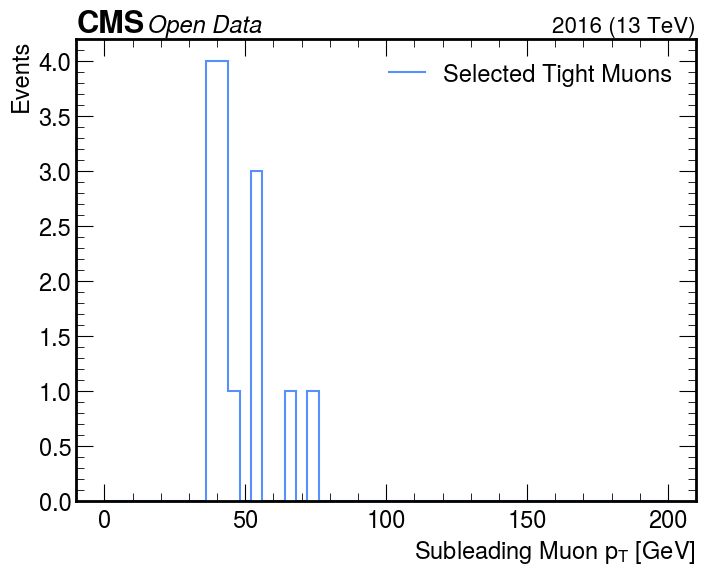

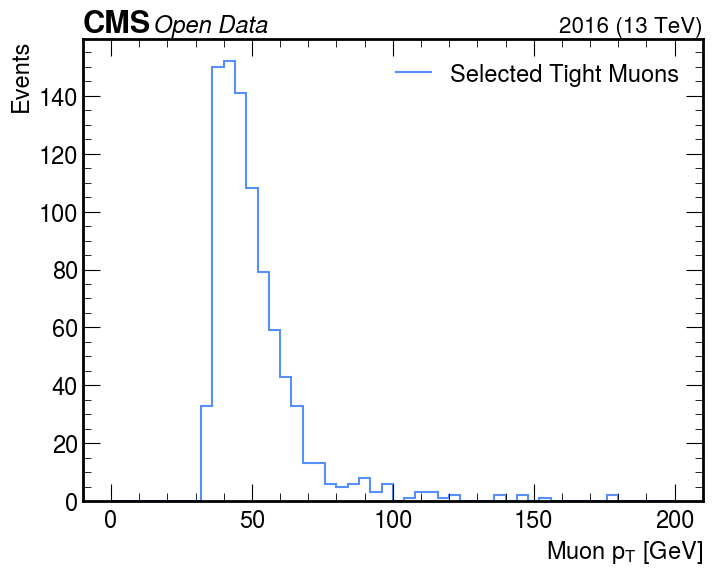

In [22]:
# Event Selection : W+c 
# Muons: HLT IsoMu24 OR HLT IsoTkMu24
# Rochester Corrections for Muons
# Muon Pt > 35 GeV, |eta| < 2.4
# I_comb = Sum(Pt(chargedhadrons)) + Et(neutralhadrons) + Et(photons) - Sum(pt(pileup))
# I_comb / pt(muon) < 0.15
# M_{T} > 55 GeV

# Jet Selection Cuts
passCuts = (RecoJets["Jet_pt"] > 30) & (abs(RecoJets["Jet_eta"]) < 2.4)
RecoJet_EvtSel = RecoJets[passCuts]

# This is the isolation cut (I_comb)
Muon_Pt_Cut = (RecoMuons["Muon_pt"] > 35)
Muon_pfIso_Cut = (abs(RecoMuons["Muon_pfRelIso04_all"] < 0.15))
Muon_Eta_Cut = (abs(RecoMuons["Muon_eta"]) < 2.4)

# Missing Trasnverse Mass Cut
# M_t = sqrt(2 * pt_muon * MET_pt * (1 - cos(mu_phi - MET_phi)))
Muon_Mt = np.sqrt(2 * RecoMuons["Muon_pt"] * METs["MET_pt"] * (1 - np.cos(RecoMuons["Muon_phi"] - METs["MET_phi"])))
Muon_Mt_Cut = (Muon_Mt > 55)  # Apply Mt cut to all tight muons

# Tight Muons 
tightMuons_Selection = Muon_Pt_Cut & Muon_pfIso_Cut & Muon_Eta_Cut & Muon_Mt_Cut  
tightMuons = RecoMuons[tightMuons_Selection]

# Pt of Leading Muon (Tight Selection)                             
Sort_tightMuons = tightMuons[ak.argsort(tightMuons["Muon_pt"], ascending=False)]
Leading_Muon_pt = ak.firsts(Sort_tightMuons["Muon_pt"])
# Leading_Muon_Mt = ak.firsts(Muon_Mt)
# Muon_Mt_Cut = (Leading_Muon_Mt > 55) # Took the Mt of the leading muon only

# Number of tight muons in the event
nTightMuons = (ak.num(Sort_tightMuons["Muon_pt"]))

# Pt of Subleading Muon (Tight Selection) 
padded_muons = ak.pad_none(Sort_tightMuons, 2, axis=1)
Subleading_Muon_pt = ak.fill_none(padded_muons[:, 1].Muon_pt, -1) #Accesses the second element of the padded array and fills None with -1

Subleading_Muon_pt_Cut = (Subleading_Muon_pt > 20) # Just a placeholder cut

# Subleading_Muon_pt = ak.pad_none(Sort_tightMuons["Muon_pt"], 2, axis=1)[:, 1] # This probably won't work
# Subleading_Muon_pt = ak.fill_none(Subleading_Muon_pt, -1)

# Selection cuts to reduce Drell-Yan contributions (OS muons)
nTightMuons_mask = (nTightMuons == 2) # Events that have two tight muons

# Sum of charges of the two tight muons should be zero (opposite sign)
tightMuon_OS_Cut = (ak.sum(Sort_tightMuons["Muon_charge"], axis=1) == 0)
OS_mask = nTightMuons_mask & tightMuon_OS_Cut & Subleading_Muon_pt_Cut
Muons_to_discard = ~OS_mask

# Final Selection Cuts
Final_Muons_Cuts = Muons_to_discard # Muon_Mt_Cut doesn't seem to work for 10K events
Selected_Muons = Sort_tightMuons[Final_Muons_Cuts]

# Some plots to visualize the selected muons
Muon_pt = ak.to_numpy(ak.flatten(Selected_Muons["Muon_pt"]))

make_hist(
    nTightMuons,
    bins=50,
    range=(0, 5),
    xlabel="Number of Muons",
    ylabel="Events",
    label="Selected Tight Muons",
    fname="../Plots/nMuon_WcAnalysis.png",
    logy=False
)

make_hist(
    Leading_Muon_pt,
    bins=50,
    range=(0, 200),
    xlabel="Leading Muon $p_{T}$ [GeV]",
    ylabel="Events",
    label="Selected Tight Muons",
    fname="../Plots/Leading_Muon_pt_WcAnalysis.png",
    logy=False
)

make_hist(
    Subleading_Muon_pt,
    bins=50,
    range=(0, 200),
    xlabel="Subleading Muon $p_{T}$ [GeV]",
    ylabel="Events",
    label="Selected Tight Muons",
    fname="../Plots/Subleading_Muon_pt_WcAnalysis.png",
    logy=False
)

make_hist(
    Muon_pt,
    bins=50,
    range=(0, 200),
    xlabel="Muon $p_{T}$ [GeV]",
    ylabel="Events",
    label="Selected Tight Muons",
    fname="../Plots/Muon_pt_WcAnalysis.png",
    logy=False
)

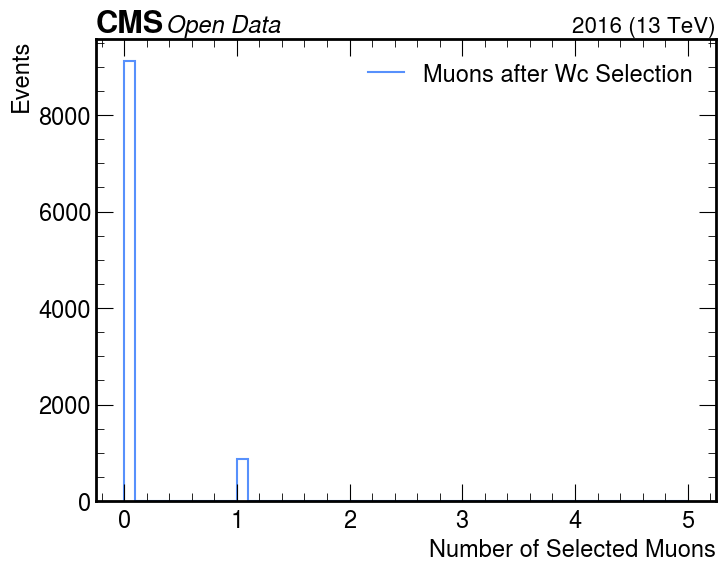

In [23]:
# Number of selected muons after Wc event selection
nSelected_Muons = ak.num(Selected_Muons["Muon_pt"])

make_hist(
    nSelected_Muons,
    bins=50,
    range=(0, 5),
    xlabel="Number of Selected Muons",
    ylabel="Events",
    label="Muons after Wc Selection",
    fname="../Plots/nSelected_Muons_WcAnalysis.png",
    logy=False
)

## W $\rightarrow$ $e + \nu$ Event Selection:

This part of the notebook selects all the events that pass the following cuts:
- Jet $p_{T}$ > 30 GeV
- Electron $p_{T}$ > 20 GeV
- Electron $\eta$ > 2.4
- Electron_pfRelIso04_all > 0.15
- $M_{T}$ > 55 GeV
- Events with two opposite signed electrons with $p_{T}$ > 20 GeV

In [53]:
print(Events.keys(filter_name="Electron_*"))

['Electron_deltaEtaSC', 'Electron_dr03EcalRecHitSumEt', 'Electron_dr03HcalDepth1TowerSumEt', 'Electron_dr03TkSumPt', 'Electron_dr03TkSumPtHEEP', 'Electron_dxy', 'Electron_dxyErr', 'Electron_dz', 'Electron_dzErr', 'Electron_eInvMinusPInv', 'Electron_energyErr', 'Electron_eta', 'Electron_hoe', 'Electron_ip3d', 'Electron_jetPtRelv2', 'Electron_jetRelIso', 'Electron_mass', 'Electron_miniPFRelIso_all', 'Electron_miniPFRelIso_chg', 'Electron_mvaFall17V2Iso', 'Electron_mvaFall17V2noIso', 'Electron_pfRelIso03_all', 'Electron_pfRelIso03_chg', 'Electron_phi', 'Electron_pt', 'Electron_r9', 'Electron_scEtOverPt', 'Electron_sieie', 'Electron_sip3d', 'Electron_mvaTTH', 'Electron_charge', 'Electron_cutBased', 'Electron_jetIdx', 'Electron_pdgId', 'Electron_photonIdx', 'Electron_tightCharge', 'Electron_vidNestedWPBitmap', 'Electron_vidNestedWPBitmapHEEP', 'Electron_convVeto', 'Electron_cutBased_HEEP', 'Electron_isPFcand', 'Electron_jetNDauCharged', 'Electron_lostHits', 'Electron_mvaFall17V2Iso_WP80', '

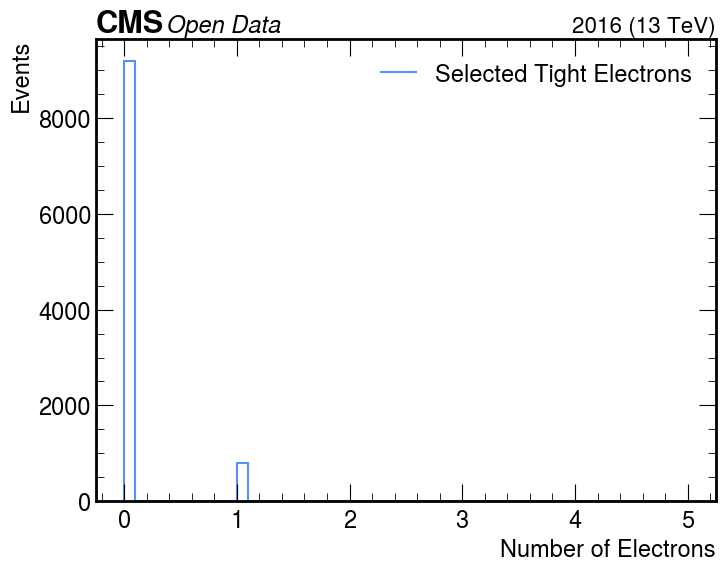

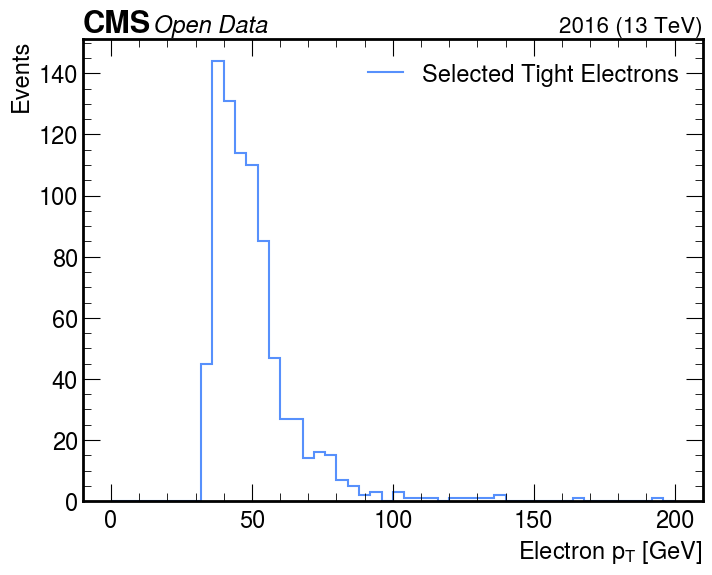

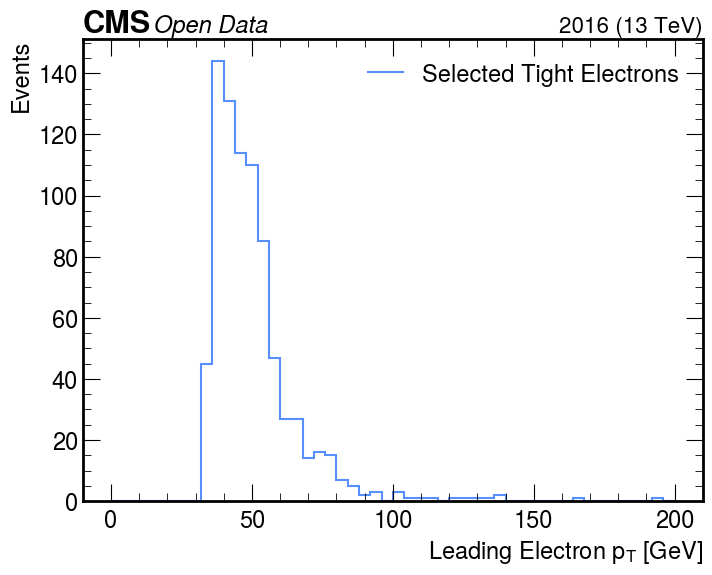

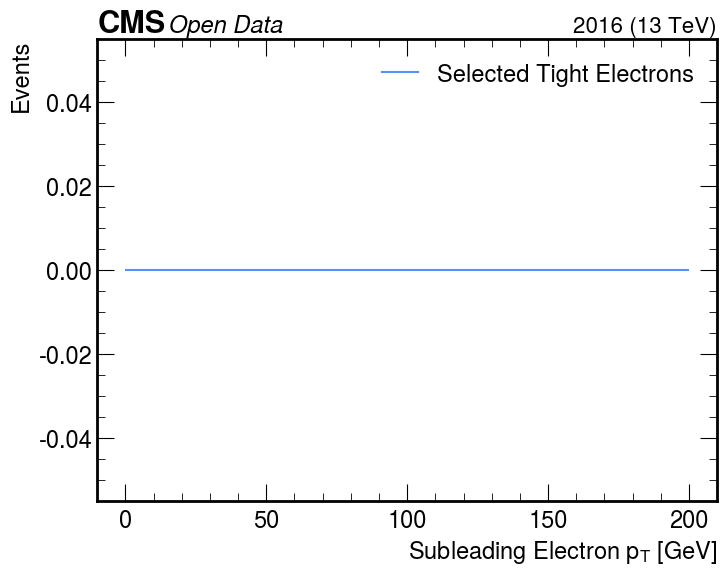

In [29]:
# Electron Selection Cuts
Electron_pt_Cut = (RecoElectrons["Electron_pt"] > 35)
Electron_pfIso_Cut = (abs(RecoElectrons["Electron_pfRelIso03_all"] < 0.15))
Electron_eta_Cut = (abs(RecoElectrons["Electron_eta"]) < 2.4)

# Missing Trasnverse Mass Cut
# M_t = sqrt(2 * pt_electron * MET_pt * (1 - cos(ele_phi - MET_phi)))
Electron_Mt = np.sqrt(2 * RecoElectrons["Electron_pt"] * METs["MET_pt"] * (1 - np.cos(RecoElectrons["Electron_phi"] - METs["MET_phi"])))
Electron_Mt_Cut = (Electron_Mt > 55)

# Tight Electrons 
tightElectrons_Selection = Electron_pt_Cut & Electron_pfIso_Cut & Electron_eta_Cut & Electron_Mt_Cut
tightElectrons = RecoElectrons[tightElectrons_Selection]

# Pt of Leading Electron (Tight Selection)                             
Sort_tightElectrons = tightElectrons[ak.argsort(tightElectrons["Electron_pt"], ascending=False)]
Leading_Electron_pt = ak.firsts(Sort_tightElectrons["Electron_pt"])
# Leading_Electron_Mt = ak.firsts(Electron_Mt)
# Electron_Mt_Cut = (Leading_Electron_Mt > 55) # Took the Mt of the leading electron only

# Number of tight Electrons in the event
nTightElectrons = (ak.num(Sort_tightElectrons["Electron_pt"]))
nTightElectrons = (ak.num(Sort_tightElectrons["Electron_pt"]))

# Pt of Subleading Electron (Tight Selection) 
padded_electrons = ak.pad_none(Sort_tightElectrons, 2, axis=1)
Subleading_Electron_pt = ak.fill_none(padded_electrons[:, 1].Electron_pt, -1) #Accesses the second element of the padded array and fills None with -1

Subleading_Electron_pt_Cut = (Subleading_Electron_pt > 20) # Just a placeholder cut

# Number of tight electrons in the event
nTightElectrons = (ak.num(tightElectrons["Electron_pt"]))

# # Selection cuts to reduce Drell-Yan contributions (OS electrons)
nTightElectrons_mask = (nTightElectrons == 2) 

# Sum of charges of the two tight electrons should be zero (opposite sign)
tightElectron_OS_Cut = (ak.sum(tightElectrons["Electron_charge"], axis=1) == 0)
OSElectron_mask = nTightElectrons_mask & tightElectron_OS_Cut & Subleading_Electron_pt_Cut

Electrons_to_discard = ~OSElectron_mask

# Final Selection Cuts
Final_Electrons_Cuts = Electrons_to_discard 
Selected_Electrons = tightElectrons[Final_Electrons_Cuts]

# Some plots to visualize the selected electrons
Electron_pt = ak.to_numpy(ak.flatten(Selected_Electrons["Electron_pt"]))

make_hist(
    nTightElectrons,
    bins=50,
    range=(0, 5),
    xlabel="Number of Electrons",
    ylabel="Events",
    label="Selected Tight Electrons",
    fname="../Plots/nElectron_WcAnalysis.png",
    logy=False
)
make_hist(
    Electron_pt,
    bins=50,
    range=(0, 200),
    xlabel="Electron $p_{T}$ [GeV]",
    ylabel="Events",
    label="Selected Tight Electrons",
    fname="../Plots/Electron_pt_WcAnalysis.png",
    logy=False
)
make_hist(
    Leading_Electron_pt,
    bins=50,
    range=(0, 200),
    xlabel="Leading Electron $p_{T}$ [GeV]",
    ylabel="Events",
    label="Selected Tight Electrons",
    fname="../Plots/Leading_Electron_pt_WcAnalysis.png",
    logy=False
)
make_hist(
    Subleading_Electron_pt,
    bins=50,
    range=(0, 200),
    xlabel="Subleading Electron $p_{T}$ [GeV]",
    ylabel="Events",
    label="Selected Tight Electrons",
    fname="../Plots/Subleading_Electron_pt_WcAnalysis.png",
    logy=False
)